In [1]:
#Some packages needs to be installed in order to run this code
#Moving Pandas is the most complicated to install
#Get anaconda - create new environment


import numpy as np
import json

import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data

#import requests
import geojson
from pyproj import CRS
#from owslib.wms import WebMapService
#from owslib.wcs import WebCoverageService

import scipy.stats as stats
from scipy.signal import lfilter

import random

#Packages for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Packages for interpreting elevation data
from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator

#MovingPandas (Kalman-filter)
import movingpandas as mpd

import hvplot.pandas 
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
import shapely as shp

from datetime import datetime, timedelta
from holoviews import opts, dim

import time

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}

import pickle

import matplotlib.colors as colors
from mycolorpy import colorlist as mcp

# Welcome to my notebook
Here we will process bicycle-data (GPS) and try to do some statistics to it.

In [2]:
#Read data into panda
df = pd.read_json(r"trip5000.json")

## Reading the data
The "issue" with geo-data is that it is in a specific format. All geodata-files contain one column with the "geography" of the dataframe. For example it could be:
* Point(1 2) - one coordinate per row
* LineString ((1 2),(2 2),(3 1)) - multiple coordinates in a line
* etc..

GeoPandas handles this type of data really well, but I've realized that when this type of data gets converted to json/csv for saving, there are some issues which can be handled in different ways.

Here we are reading from a json-file and in order to write geodata to json the geodata has to be converted to a "feature", which is why we are reading it like this: first as a dataframe, and then from_features we read it as a geodataframe. Then GeoPandas knows what it's dealing with. 

We will also read from some other formats later, and will go through those when we get to them.

## csr
crs is the coordinate reference system. We want to use the same crs as the original data was projected onto, and this data was projected onto epsg:4617. This is a "degree" based coordinate-system and we will use it throughout (with some minor exeptions)

In [3]:
#Read the data as a geodataframe
gdf = gpd.GeoDataFrame.from_features(df["features"])
gdf = gdf.set_crs('epsg:4617') 

<Axes: >

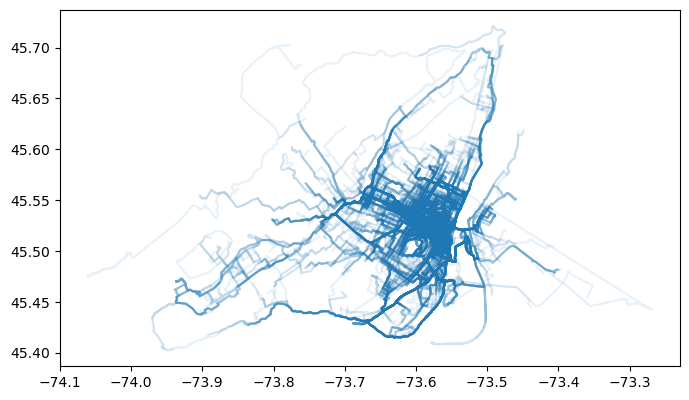

In [4]:
gdf.plot(alpha=0.1,figsize=(8, 8))

In [5]:
gdf.head(3)

,geometry,stop,id_origine,start,length,purpose,liste_segments_jsonb,n_coord,id
0,"LINESTRING (-73.57748 45.50690, -73.57751 45.5...",2013-06-25 16:34:16,52,2013-06-25 16:21:21,3163,Commute,"[{'source': 'GEOBASE', 'id': 1260962}, {'sourc...",511,52
1,"LINESTRING (-73.62897 45.46372, -73.62891 45.4...",2013-07-25 14:40:06,2325,2013-07-25 14:37:42,1066,Courses,"[{'source': 'GEOBASE', 'id': 1310311}, {'sourc...",196,2325
2,"LINESTRING (-73.58481 45.56786, -73.58153 45.5...",2013-07-25 14:43:12,2326,2013-07-25 14:19:15,5619,Courses,"[{'source': 'GEOBASE', 'id': 1170061}, {'sourc...",1036,2326


## Initial process
The data we have is one row per trip. With the coordinates being in the LineString-form mentioned above.
Below we:
* let the computer know that our date/time-data is actually datetime-data
* Calculate the duration of each trip (in seconds) and add that column to the dataframe
* Split each LineString  into a MultiLineString of individual segments: [(a, b, c)] -> [(c,a), (a,b), (b,c)]
* Explode that MultiLineString: 

               1 [(a, b, c)] [data1]  -> [(c,a), (a,b), (b,c)] [data1]
               2 [(d, e, f)] [data2]  -> [(f,d), (d,e), (e,f)] [data2]
               --->
               1 1 [(c,a)]  [data1]
               1 2 [(a,b)]  [data1]
               1 3 [(b,c)]  [data1]
               2 1 [(f,d)]  [data2]
               2 2 [(d,e)]  [data2]
               2 3 [(e,f)]  [data2]

In [6]:
gdf["start"] = pd.to_datetime(gdf['start'])
gdf["stop"] = pd.to_datetime(gdf['stop'])
gdf["duration"] = (gdf['stop'] - gdf['start']) / pd.Timedelta(seconds=1)

In [7]:
#Here we split each linestring into a multilinestring of individual segments [a, b, c] -> [(c,a), (a,b), (b,c)]
#this also means that the first element needs to be deleted
#It takes like 10 minutes but it is by far the fasted method i've found
gdf["geo"] = gdf.apply(lambda x: MultiLineString([LineString([x['geometry'].coords[i-1], x['geometry'].coords[i]]) for i in range(len(x['geometry'].coords))]),axis=1)


#Make that into the geometry
gdf.set_geometry("geo", drop=False, inplace=True, crs='epsg:4617')
#And explode it based on geo
gdf = gdf.explode(index_parts=True)
gdf.dropna(inplace=True)

In [8]:
#also drop geometry because it is confusing to have two geometries.
#our actual geometry-column is called "geo", this column is the original LineString and not needed
#All trips have unique indices so we can recreate this LineString if needed
gdf.drop("geometry", axis=1, inplace=True)
gdf.drop("liste_segments_jsonb", axis=1, inplace=True)

## Add length
To add length of the segments we want to project the data onto a coordinate reference system (crs) which is in meters. One such corresponding to espg:4617 is espg:3979. This does take some time so only do this once.

In [9]:
gdf["length"] = gdf.to_crs('epsg:3979').length
gdf.dropna(inplace=True)

## Save point

In [10]:
gdf.to_csv('00gdf_firstsave.csv')

In [11]:
gdf

stop  id_origine               start       length  \
0    0  2013-06-25 16:34:16          52 2013-06-25 16:21:21  2578.232646   
     1  2013-06-25 16:34:16          52 2013-06-25 16:21:21     3.259530   
     2  2013-06-25 16:34:16          52 2013-06-25 16:21:21    11.615175   
     3  2013-06-25 16:34:16          52 2013-06-25 16:21:21    14.267484   
     4  2013-06-25 16:34:16          52 2013-06-25 16:21:21    21.120836   
...                     ...         ...                 ...          ...   
4880 55 2015-08-31 14:48:18       28938 2015-08-31 14:46:36     8.120286   
     56 2015-08-31 14:48:18       28938 2015-08-31 14:46:36     8.767340   
     57 2015-08-31 14:48:18       28938 2015-08-31 14:46:36     7.957226   
     58 2015-08-31 14:48:18       28938 2015-08-31 14:46:36     2.979232   
     59 2015-08-31 14:48:18       28938 2015-08-31 14:46:36   169.814013   

            purpose  n_coord     id  duration  \
0    0      Commute      511     52     775.0   
     1      Commute      511     52     775.0   
     2      Commute      511     52     775.0   
     3      Commute      511     52     775.0   
     4      Commute      511     52     775.0   
...             ...      ...    ...       ...   
4880 55  Magasinage       93  28938     102.0   
     56  Magasinage       93  28938     102.0   
     57  Magasinage       93  28938     102.0   
     58  Magasinage       93  28938     102.0   
     59  Magasinage       93  28938     102.0   

                                                       geo  
0    0   LINESTRING (-73.60445 45.51966, -73.57748 45.5...  
     1   LINESTRING (-73.57748 45.50690, -73.57751 45.5...  
     2   LINESTRING (-73.57751 45.50692, -73.57757 45.5...  
     3   LINESTRING (-73.57757 45.50701, -73.57774 45.5...  
     4   LINESTRING (-73.57774 45.50705, -73.57792 45.5...  
...                                                    ...  
4880 55  LINESTRING (-73.54475 45.54151, -73.54478 45.5...  
     56  LINESTRING (-73.54478 45.54145, -73.54482 45.5...  
     57  LINESTRING (-73.54482 45.54137, -73.54486 45.5...  
     58  LINESTRING (-73.54486 45.54131, -73.54490 45.5...  
     59  LINESTRING (-73.54490 45.54130, -73.54697 45.5...  

[4331910 rows x 9 columns]

We know that because of the anonymization the first and last few datapoints are bad, so we remove them if they are.

Here we:
* create new column with only zeros: "head"=0
* set all first 10 datapoints in each trip to: "head"= 1
* create new column with only zeros: "long"=0
* set all datapoints with "length">50 to: "long"=1
* new column: "bad_start" = "head" * "long", 
* so that "bad_start"=1 iff this point is both in the beginning of the trip *and* too long
* do a backwards cumulative sum group-wise so that if say datapoint 7 is bad, then "bad_start" for all preceding points in this trip will be >=1, but if none of them are bad, all will be zero
* delete all points with a "bad_start" value >=0
* drop all columns you created, because you won't need them

We then to the same this "backwards" for bad end-points

In [12]:
#If any segement in of the first ten are longer than 50 meter - delete that + all segments prior
gdf["head"] = 0
gdf.loc[gdf.groupby(level=0).head(10).index.tolist(), "head"] = 1
gdf["long"] = 0
gdf.loc[gdf["length"]>=50, "long"] = 1
gdf["bad_start"] = gdf["head"]*gdf["long"]
gdf['bad_start'] = gdf.loc[::-1, 'bad_start'].groupby(level=0).cumsum()[::-1]
gdf.drop(gdf.loc[gdf["bad_start"]>0].index.tolist(), inplace=True)
gdf.drop(columns=["head", "bad_start"], inplace=True)

In [13]:
#If any segement in of the last ten are longer than 50 meter - delete that + all segments after
gdf["tail"] = 0
gdf.loc[gdf.groupby(level=0).tail(10).index.tolist(), "tail"] = 1
gdf["bad_end"] = gdf["tail"]*gdf["long"]
gdf['bad_end'] = gdf.groupby(level=0)["bad_end"].cumsum()
gdf.drop(gdf.loc[gdf["bad_end"]>0].index.tolist(), inplace=True)
gdf.drop(columns=["tail", "bad_end", "long"], inplace=True)

In [14]:
print("the mean length of a segment is:",gdf["length"].mean())

the mean length of a segment is: 6.6577990877631485


## dt
We now have the dt which is duration/tot_coord
and can add time to all segments
It is important to remember that the time we add corresponds to THE LAST coordinate in segment
(all segments contains two coordinates: start and end of)
we:
* calculate the mean dt for all trips and set dt_tillf
* set dt to dt_tillf but in datetime
* find how much datetime the coordinate is from the start of the trip: "end_timestamp"
* let the time "t" of the point be start-time of trip + end_timestamp

we dont drop stuff just yet, because we will need them in a sec to take care of the first segment in each trip (remember, its starting point is actually the endpoint of the trip)

In [15]:
gdf["dt_tillf"] = ((gdf.groupby(level=0)["duration"].mean()).sum())/((gdf.groupby(level=0)["n_coord"].mean()).sum())

gdf["dt"] = gdf["dt_tillf"].apply(lambda x: timedelta(seconds=x))

gdf["end_timestamp"] = gdf.groupby(level=0, group_keys=False)["dt"].cumsum()
gdf.drop("dt_tillf", axis=1, inplace=True)

#timestamp AGAIN, FOR THE END COORDINATE OF THE SEGMENT
gdf["t"] = gdf["start"] + gdf["end_timestamp"]

## One idea is to cut up the trips
where we have any segments w/o gps.reading that are much longer than we expect.
Specifically longer than 38 meter (0.999 quantile) and reindex accordingly. \
\
The idea is to reconnect them (or their velocity data) after processing

In [16]:
gdf.reset_index(level=0, inplace=True)
lost_idx = gdf.columns[0]
gdf["long"] = 0
gdf.loc[gdf["length"]>= gdf["length"].quantile(0.999), "long"] = 1 
gdf["long"] = gdf["long"].cumsum()
gdf["trajectory_id"] = gdf[lost_idx] + gdf["long"]

gdf.set_index(["trajectory_id"], append=True, drop=False, inplace=True)
gdf = gdf.swaplevel().copy()

gdf["long"] = 0
gdf.loc[gdf["length"]>= gdf["length"].quantile(0.999), "long"] = np.nan
gdf.dropna(inplace=True)
gdf.drop(columns=[lost_idx, "long"], inplace=True)

In [17]:
# We go from around 5000 trips ("id_origine") to around 9000 "trips" ("trajectory_id")
gdf.head(3)

stop  id_origine               start  \
trajectory_id                                                         
0             1 2013-06-25 16:34:16          52 2013-06-25 16:21:21   
              2 2013-06-25 16:34:16          52 2013-06-25 16:21:21   
              3 2013-06-25 16:34:16          52 2013-06-25 16:21:21   

                    length  purpose  n_coord  id  duration  \
trajectory_id                                                
0             1   3.259530  Commute      511  52     775.0   
              2  11.615175  Commute      511  52     775.0   
              3  14.267484  Commute      511  52     775.0   

                                                               geo  \
trajectory_id                                                        
0             1  LINESTRING (-73.57748 45.50690, -73.57751 45.5...   
              2  LINESTRING (-73.57751 45.50692, -73.57757 45.5...   
              3  LINESTRING (-73.57757 45.50701, -73.57774 45.5...   

                                    dt          end_timestamp  \
trajectory_id                                                   
0             1 0 days 00:00:01.171521 0 days 00:00:01.171521   
              2 0 days 00:00:01.171521 0 days 00:00:02.343042   
              3 0 days 00:00:01.171521 0 days 00:00:03.514563   

                                         t  trajectory_id  
trajectory_id                                              
0             1 2013-06-25 16:21:22.171521              0  
              2 2013-06-25 16:21:23.343042              0  
              3 2013-06-25 16:21:24.514563              0

# Now, unfortunately the Kalmanfilter needs point-geometry 
We will add an index to each trip which is the starting-point ("t"="start")
this needs to be handled separately because this coord should be the first in the segment after

In [18]:
#Copy all first points
gdf_test= gdf.copy()
gdf_head = gdf_test.groupby(level=0).head(1).copy()

#change timestamps
gdf_head["end_timestamp"] = timedelta(seconds=0)
gdf_head["t"] = gdf_head["start"]
#set the segment to a line between start and start-point (so that x[0].coords[1] = x[1].coords[0])
gdf_head["geo"] = gdf_head["geo"].apply(lambda x: LineString([Point(x.coords[0]), Point(x.coords[0])]))
gdf_head["length"] = 0
#Change indexing so concat works
idx_name = gdf_test.reset_index(level=1).columns[0]
gdf_head[idx_name] = [0 for x in range(len(gdf_head))]

gdf_head.reset_index(level=1,drop=True,inplace=True)
gdf_head.set_index(idx_name, append=True,inplace=True)
##concat (add) the two df together, and sort index
gdf_done = pd.concat([gdf_head.astype(gdf_test.dtypes), gdf_test])
gdf_done.sort_index(inplace=True)

In [19]:
gdf_done.head(3)

stop  id_origine               start  \
trajectory_id                                                         
0             0 2013-06-25 16:34:16          52 2013-06-25 16:21:21   
              1 2013-06-25 16:34:16          52 2013-06-25 16:21:21   
              2 2013-06-25 16:34:16          52 2013-06-25 16:21:21   

                    length  purpose  n_coord  id  duration  \
trajectory_id                                                
0             0   0.000000  Commute      511  52     775.0   
              1   3.259530  Commute      511  52     775.0   
              2  11.615175  Commute      511  52     775.0   

                                                               geo  \
trajectory_id                                                        
0             0  LINESTRING (-73.57748 45.50690, -73.57748 45.5...   
              1  LINESTRING (-73.57748 45.50690, -73.57751 45.5...   
              2  LINESTRING (-73.57751 45.50692, -73.57757 45.5...   

                                    dt          end_timestamp  \
trajectory_id                                                   
0             0 0 days 00:00:01.171521        0 days 00:00:00   
              1 0 days 00:00:01.171521 0 days 00:00:01.171521   
              2 0 days 00:00:01.171521 0 days 00:00:02.343042   

                                         t  trajectory_id  
trajectory_id                                              
0             0 2013-06-25 16:21:21.000000              0  
              1 2013-06-25 16:21:22.171521              0  
              2 2013-06-25 16:21:23.343042              0

In [20]:
#Keep going
gdf = gdf_done.copy()

In [21]:
#create new column with last coord in segment as point
gdf["geometry"] = gdf["geo"].apply(lambda x: Point(x.coords[1]))

#change geom to point
gdf.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [22]:
gdf_done = gdf.copy() #SAVE HERE IF YOU MESS UP :)

In [23]:
gdf.drop(columns=["n_coord", "start", "stop", "end_timestamp"], inplace=True)

gdf["id"] = [x for x in range(len(gdf))]
gdf.set_index(["id"], inplace=True,
             append=True, drop=False)


In [24]:
gdf.reset_index(level=0,drop=True, inplace=True)
gdf.reset_index(level=0,drop=True, inplace=True)

### Current dataframe
* id: individual index
* id_origine: original trip index
* length: length from this point to the next one
* purpose: purpose of og trip
* duration: og duration
* geo: NOT GEOMETRY of dataframe but the linesegment from current point to next (this segment has length="length")
* dt: mean time (same for all)
* t: "actual" (approximated) time of recordning coordinate
* trajectory_id: index for this "trip" after cutting up some trips
* geometry: GEOMETRY of dataframe - point coordinate

In [25]:
gdf.head(3)

,id_origine,length,purpose,id,duration,geo,dt,t,trajectory_id,geometry
id,,,,,,,,,,
0,52,0.000000,Commute,0,775.0,"LINESTRING (-73.57748 45.50690, -73.57748 45.5...",0 days 00:00:01.171521,2013-06-25 16:21:21.000000,0,POINT (-73.57748 45.50690)
1,52,3.259530,Commute,1,775.0,"LINESTRING (-73.57748 45.50690, -73.57751 45.5...",0 days 00:00:01.171521,2013-06-25 16:21:22.171521,0,POINT (-73.57751 45.50692)
2,52,11.615175,Commute,2,775.0,"LINESTRING (-73.57751 45.50692, -73.57757 45.5...",0 days 00:00:01.171521,2013-06-25 16:21:23.343042,0,POINT (-73.57757 45.50701)


## Save point

In [26]:
gdf.to_csv('00gdf_beforeKM.csv')

## Read from save-point

In [3]:
#gdf = pd.read_csv('00gdf_beforeKM.csv')
#gdf.drop("id.1", axis=1, inplace=True)
#gdf = gpd.GeoDataFrame(gdf)
#gdf["geometry"] = gdf['geometry'].apply(wkt.loads)

#gdf.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [27]:
gdf

,id_origine,length,purpose,id,duration,geo,dt,t,trajectory_id,geometry
id,,,,,,,,,,
0,52,0.000000,Commute,0,775.0,"LINESTRING (-73.57748 45.50690, -73.57748 45.5...",0 days 00:00:01.171521,2013-06-25 16:21:21.000000,0,POINT (-73.57748 45.50690)
1,52,3.259530,Commute,1,775.0,"LINESTRING (-73.57748 45.50690, -73.57751 45.5...",0 days 00:00:01.171521,2013-06-25 16:21:22.171521,0,POINT (-73.57751 45.50692)
2,52,11.615175,Commute,2,775.0,"LINESTRING (-73.57751 45.50692, -73.57757 45.5...",0 days 00:00:01.171521,2013-06-25 16:21:23.343042,0,POINT (-73.57757 45.50701)
3,52,14.267484,Commute,3,775.0,"LINESTRING (-73.57757 45.50701, -73.57774 45.5...",0 days 00:00:01.171521,2013-06-25 16:21:24.514563,0,POINT (-73.57774 45.50705)
4,52,21.120836,Commute,4,775.0,"LINESTRING (-73.57774 45.50705, -73.57792 45.5...",0 days 00:00:01.171521,2013-06-25 16:21:25.686084,0,POINT (-73.57792 45.50718)
...,...,...,...,...,...,...,...,...,...,...
4325932,28938,6.976099,Magasinage,4325932,102.0,"LINESTRING (-73.54472 45.54157, -73.54475 45.5...",0 days 00:00:01.171521,2015-08-31 14:47:39.262134,9202,POINT (-73.54475 45.54151)
4325933,28938,8.120286,Magasinage,4325933,102.0,"LINESTRING (-73.54475 45.54151, -73.54478 45.5...",0 days 00:00:01.171521,2015-08-31 14:47:40.433655,9202,POINT (-73.54478 45.54145)
4325934,28938,8.767340,Magasinage,4325934,102.0,"LINESTRING (-73.54478 45.54145, -73.54482 45.5...",0 days 00:00:01.171521,2015-08-31 14:47:41.605176,9202,POINT (-73.54482 45.54137)


In [65]:
# IF you do not read from save-point run the following two lines

#gdf.drop(columns=["id"],inplace=True)
#gdf.reset_index(level=0, drop=False,inplace=False)

# So far the only thing we have done with the data is to decide how to interpret the size of the timestep.
This is not unimportant and will effect the data alot
but still, most of the code above is just reading and parsing data.

# KalmanFilter

In [28]:
mpd.show_versions()


MovingPandas 0.18.0

SYSTEM INFO
-----------
python     : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:35:20) [Clang 16.0.6 ]
executable : /Users/johannaskantorp/anaconda3/envs/myenv/bin/python
machine    : macOS-14.5-arm64-arm-64bit

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.2
GDAL data dir: /Users/johannaskantorp/anaconda3/envs/myenv/share/gdal
PROJ       : 9.3.1
PROJ data dir: /Users/johannaskantorp/anaconda3/envs/myenv/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.14.4
pandas     : 2.2.1
fiona      : 1.9.5
numpy      : 1.26.4
shapely    : 2.0.1
rtree      : 1.0.1
pyproj     : 3.6.1
matplotlib : 3.8.4
mapclassify: 2.5.0
geopy      : 2.4.1
holoviews  : 1.18.3
hvplot     : 0.10.0
geoviews   : None
stonesoup  : 1.2


## First we smooth with three different process noise std's
And this would take so long we only do it to the first 1000 trips in the dataset
\
## Save point 

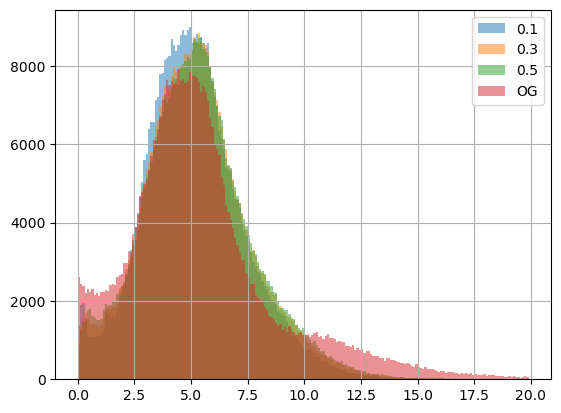

In [184]:
label = [str(x) for x in stds] + ["OG"]

for i in range(len(gdfs)):
    frame = gdfs[i]
    
    frame["speed"].hist(bins=[x*0.1 for x in range(200)], label=label[i], alpha = 0.5)
    
plt.legend()
plt.show()

# Make a decicion on which to use
Again, needs to be motivated,
currently running with: 
* process_noise_std=2, 
* measurement_noise_std=10

In [50]:
gdf_test = gdf.copy() #gdf.copy()#gdf.loc[gdf["trajectory_id"]<=1000].copy()
gdf_test.drop(columns=["geo"], inplace=True)

In [51]:
gdf_test

,id_origine,length,purpose,id,duration,dt,t,trajectory_id,geometry
id,,,,,,,,,
0,52,0.000000,Commute,0,775.0,0 days 00:00:01.171521,2013-06-25 16:21:21.000000,0,POINT (-73.57748 45.50690)
1,52,3.259530,Commute,1,775.0,0 days 00:00:01.171521,2013-06-25 16:21:22.171521,0,POINT (-73.57751 45.50692)
2,52,11.615175,Commute,2,775.0,0 days 00:00:01.171521,2013-06-25 16:21:23.343042,0,POINT (-73.57757 45.50701)
3,52,14.267484,Commute,3,775.0,0 days 00:00:01.171521,2013-06-25 16:21:24.514563,0,POINT (-73.57774 45.50705)
4,52,21.120836,Commute,4,775.0,0 days 00:00:01.171521,2013-06-25 16:21:25.686084,0,POINT (-73.57792 45.50718)
...,...,...,...,...,...,...,...,...,...
4325932,28938,6.976099,Magasinage,4325932,102.0,0 days 00:00:01.171521,2015-08-31 14:47:39.262134,9202,POINT (-73.54475 45.54151)
4325933,28938,8.120286,Magasinage,4325933,102.0,0 days 00:00:01.171521,2015-08-31 14:47:40.433655,9202,POINT (-73.54478 45.54145)
4325934,28938,8.767340,Magasinage,4325934,102.0,0 days 00:00:01.171521,2015-08-31 14:47:41.605176,9202,POINT (-73.54482 45.54137)


In [52]:
std=2
tc = mpd.TrajectoryCollection(gdf_test, traj_id_col='trajectory_id', obj_id_col="id", t="t")
smooth = mpd.KalmanSmootherCV(tc).smooth(process_noise_std=std, measurement_noise_std=10)
smooth.add_speed()

TrajectoryCollection with 8489 trajectories

In [53]:
tc.add_speed()
tc_save = tc.to_point_gdf()

In [54]:
gm = smooth.to_point_gdf()

# Stops
we define a stop as not moving outside of a diameter of 30 meters in 20 seconds \
this might be a bad choice - look into further. \
We do this by creating a column which 
* = 1 if part of stop
* = 0 if not
* = 2 if lowest velocity in stopping period

In [55]:
detector = mpd.TrajectoryStopDetector(smooth)
stops = detector.get_stop_segments(min_duration=timedelta(seconds=20), max_diameter=30)
gdf_stops = stops.to_point_gdf()

In [56]:
but_point = gdf_stops.set_index(["trajectory_id"], inplace=False,
             append=True, drop=False).swaplevel().groupby(level=0)["speed"].idxmin().tolist()

In [57]:
cut_point = [x[1] for x in but_point]

In [58]:
gm["stop"] = 0
gm.loc[gdf_stops.index, "stop"] = 1
gm.loc[cut_point, "stop"] = 2

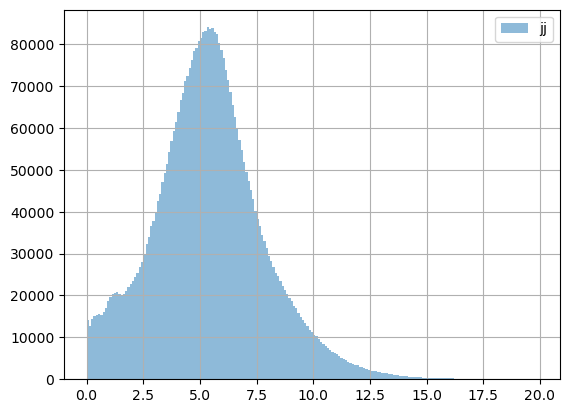

In [59]:
label="jj"
frame = gm

frame["speed"].hist(bins=[x*0.1 for x in range(200)], label=label, alpha = 0.5)
    
plt.legend()
plt.show()

## save point
We save both the processed trips (gm) and the unprocessed trips (tc_save) \
tc_save is basically gdf, but in in the same "form" as gm (what movingpandas calls a trajectory-collection). But it's convenient that they are similar, so we use this instead of gdf going forward.

In [60]:
gm.to_csv("00gm_KM2.csv")
tc_save.to_csv('00OG_kf.csv')

# start from here

In [61]:
#gm = pd.read_csv('gm_kf.csv')
gm = pd.read_csv('00gm_KM2.csv')
gm.set_index(["t"],inplace=True)
gm = gpd.GeoDataFrame(gm)
gm["geometry"] = gm['geometry'].apply(wkt.loads)
gm.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [62]:
tc_save = pd.read_csv('00OG_kf.csv')
tc_save.set_index(["t"],inplace=True)
tc_save = gpd.GeoDataFrame(tc_save)
tc_save["geometry"] = tc_save['geometry'].apply(wkt.loads)
tc_save.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

Since the Kalman-filter only shifts the positions we expect these to be identical except for 
* geometry
* speed
* stop (which does not exist for tc_save)

In [63]:
tc_save

,id_origine,length,purpose,id,duration,dt,trajectory_id,geometry,speed
t,,,,,,,,,
2013-06-25 16:21:21.000000,52,0.000000,Commute,0,775.0,0 days 00:00:01.171521,0,POINT (-73.57748 45.50690),2.741158
2013-06-25 16:21:22.171521,52,3.259530,Commute,1,775.0,0 days 00:00:01.171521,0,POINT (-73.57751 45.50692),2.741158
2013-06-25 16:21:23.343042,52,11.615175,Commute,2,775.0,0 days 00:00:01.171521,0,POINT (-73.57757 45.50701),9.767984
2013-06-25 16:21:24.514563,52,14.267484,Commute,3,775.0,0 days 00:00:01.171521,0,POINT (-73.57774 45.50705),11.998494
2013-06-25 16:21:25.686084,52,21.120836,Commute,4,775.0,0 days 00:00:01.171521,0,POINT (-73.57792 45.50718),17.761949
...,...,...,...,...,...,...,...,...,...
2015-08-31 14:47:39.262134,28938,6.976099,Magasinage,4325932,102.0,0 days 00:00:01.171521,9202,POINT (-73.54475 45.54151),5.867616
2015-08-31 14:47:40.433655,28938,8.120286,Magasinage,4325933,102.0,0 days 00:00:01.171521,9202,POINT (-73.54478 45.54145),6.829993
2015-08-31 14:47:41.605176,28938,8.767340,Magasinage,4325934,102.0,0 days 00:00:01.171521,9202,POINT (-73.54482 45.54137),7.374229


In [64]:
gm

,id_origine,length,purpose,id,duration,dt,trajectory_id,geometry,speed,stop
t,,,,,,,,,,
2013-06-25 16:21:21.000000,52,0.000000,Commute,0,775.0,0 days 00:00:01.171521,0,POINT (-73.57756 45.50696),2.292727,0
2013-06-25 16:21:22.171521,52,3.259530,Commute,1,775.0,0 days 00:00:01.171521,0,POINT (-73.57758 45.50697),2.292727,0
2013-06-25 16:21:23.343042,52,11.615175,Commute,2,775.0,0 days 00:00:01.171521,0,POINT (-73.57766 45.50702),6.479299,0
2013-06-25 16:21:24.514563,52,14.267484,Commute,3,775.0,0 days 00:00:01.171521,0,POINT (-73.57777 45.50708),9.750530,0
2013-06-25 16:21:25.686084,52,21.120836,Commute,4,775.0,0 days 00:00:01.171521,0,POINT (-73.57791 45.50716),11.787352,0
...,...,...,...,...,...,...,...,...,...,...
2015-08-31 14:47:39.262134,28938,6.976099,Magasinage,4325932,102.0,0 days 00:00:01.171521,9202,POINT (-73.54475 45.54150),5.666642,0
2015-08-31 14:47:40.433655,28938,8.120286,Magasinage,4325933,102.0,0 days 00:00:01.171521,9202,POINT (-73.54479 45.54144),5.793367,0
2015-08-31 14:47:41.605176,28938,8.767340,Magasinage,4325934,102.0,0 days 00:00:01.171521,9202,POINT (-73.54482 45.54139),5.830017,0


In [65]:
# just a safety measure
gm_savepoint = gm.copy()

### clean up
* rename "speed" to "vel" because I did not fully plan this code
* add "acc" = "diff in vel" (for now) 
* add and re-order index (for some reason reorder_levels does not have inplace)
* create time-columns for calculating actual acceleration
* compute acceleration (i.e. divide by time)
* NOTE: when we later "reattach" the trips there will be an odd "zero acceleration" at the junctions

In [72]:
gm.rename(columns={"speed":"vel"}, inplace=True)
tc_save.rename(columns={"speed":"vel"}, inplace=True)

In [73]:
gm["acc"] = -gm["vel"].diff(periods=-1)
tc_save["acc"] = -tc_save["vel"].diff(periods=-1)

In [74]:
gm.set_index(["trajectory_id"], inplace=True,
             append=True, drop=True)
gm = gm.reorder_levels(["trajectory_id", "t"]).copy()

tc_save.set_index(["trajectory_id"], inplace=True,
              append=True, drop=True)
tc_save = tc_save.reorder_levels(["trajectory_id", "t"]).copy()

In [75]:
#create a column which is dt but in seconds
gm["time"] = pd.to_timedelta(gm["dt"]).dt.total_seconds()

gm["timesum"] = gm.groupby(level=0)["time"].cumsum()


tc_save["time"] = pd.to_timedelta(tc_save["dt"]).dt.total_seconds()
tc_save["timesum"] = tc_save.groupby(level=0)["time"].cumsum()

In [76]:
# acceleration should be set to zero if we are at the end or beginning of a trajectory
gm.loc[gm.groupby("trajectory_id").tail(1).index, "acc"] = 0
tc_save.loc[tc_save.groupby("trajectory_id").tail(1).index, "acc"] = 0

In [77]:
gm["acc"] = gm["acc"]/gm["time"]
tc_save["acc"] = tc_save["acc"]/tc_save["time"]

# Done

Meet your dataframe:
Currently it consists of 
* trajectory_id (level=0)
* segment index (level=1)
* purpose of trip
* duration; [s] according to og data 
* dt; time for segment in datetime (all the same)
* geometry; point geometry
* id; relic of kalmanfilter
* length; [m] length of linesegment: NO LONGER TRUE AFTER SMOOTHING (True for tc_save)
* vel; [m/s] vel after smoothing
* stop; 1 if point is part of a stop, 0 else, 2 if cutting point
* time; mean time between GPS readings



* elev; [m] elevation in first point of linestring/point geom

In [ ]:
#gm.set_index(["id_origine"], inplace=True,
#             append=True, drop=True)
#gm = gm.reorder_levels(["trajectory_id", "t"]).copy()

## Let's put the trips back together
The only reason we cut them was to not give any weigth to the segments where we lost contact, but there are some other issues instead:
* The kalman filter will always assume we start at zero. Which means we will get some weird behaviour around where we reattach the trajectories into trips.
* We regroup the trips under their original id (id_origine)
* We cut the first 7 elements of each trajectory id that 

In [107]:
gm["id"] = (gm.droplevel(1)).index.tolist()

In [108]:
gm.set_index(["id_origine"], inplace=True,
             append=True, drop=True)

In [110]:
gm = gm.droplevel(0).copy()
gm["origine"] = (gm.droplevel(0)).index.tolist()

In [192]:
gm["tf"] = 1

In [193]:
id_list = gm.groupby(level=1)["id"].unique().tolist()
origine_list = gm.groupby(level=1)["origine"].unique().tolist()

In [196]:
gm.loc[gm.groupby(["origine", "id"]).head(7).index, "tf"] = np.nan

In [199]:
gm.loc[gm.groupby("origine").head(7).index, "tf"] = 1

In [201]:
gm.dropna(inplace = True)

In [202]:
gm

,,length,purpose,id,duration,dt,geometry,vel,stop,acc,time,timesum,origine,tf
t,id_origine,,,,,,,,,,,,,
2013-06-25 16:21:21.000000,52,0.000000,Commute,0,775.0,0 days 00:00:01.171521,POINT (-73.57756 45.50696),2.292727,0,-0.000000,1.171521,1.171521,52,1.0
2013-06-25 16:21:22.171521,52,3.259530,Commute,0,775.0,0 days 00:00:01.171521,POINT (-73.57758 45.50697),2.292727,0,3.573622,1.171521,2.343042,52,1.0
2013-06-25 16:21:23.343042,52,11.615175,Commute,0,775.0,0 days 00:00:01.171521,POINT (-73.57766 45.50702),6.479299,0,2.792294,1.171521,3.514563,52,1.0
2013-06-25 16:21:24.514563,52,14.267484,Commute,0,775.0,0 days 00:00:01.171521,POINT (-73.57777 45.50708),9.750530,0,1.738613,1.171521,4.686084,52,1.0
2013-06-25 16:21:25.686084,52,21.120836,Commute,0,775.0,0 days 00:00:01.171521,POINT (-73.57791 45.50716),11.787352,0,0.535669,1.171521,5.857605,52,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-31 14:47:39.262134,28938,6.976099,Magasinage,9202,102.0,0 days 00:00:01.171521,POINT (-73.54475 45.54150),5.666642,0,0.108171,1.171521,63.262134,28938,1.0
2015-08-31 14:47:40.433655,28938,8.120286,Magasinage,9202,102.0,0 days 00:00:01.171521,POINT (-73.54479 45.54144),5.793367,0,0.031284,1.171521,64.433655,28938,1.0
2015-08-31 14:47:41.605176,28938,8.767340,Magasinage,9202,102.0,0 days 00:00:01.171521,POINT (-73.54482 45.54139),5.830017,0,-0.052704,1.171521,65.605176,28938,1.0


# Now we want to change back to the original index 

In [203]:
gm = gm.reorder_levels(["id_origine", "t"]).copy()

In [252]:
gm.groupby(level=0).tail(1).index

MultiIndex([(   52, '2013-06-25 16:29:16.637526'),
            ( 2325, '2013-07-25 14:39:09.864075'),
            ( 2326, '2013-07-25 14:35:56.650455'),
            (   53, '2013-06-25 16:28:13.546913'),
            (   56, '2013-06-26 12:59:56.294473'),
            (  132, '2013-07-02 12:24:01.352747'),
            (  133, '2013-07-02 12:28:53.909343'),
            ( 2355, '2013-07-25 17:08:13.391545'),
            ( 3045, '2013-07-30 10:47:55.957802'),
            ( 3046, '2013-07-30 09:47:00.931988'),
            ...
            (28942, '2015-08-31 14:32:28.155335'),
            (28834, '2015-08-29 11:03:58.906141'),
            (28848, '2015-08-26 09:11:44.000000'),
            (28849, '2015-08-29 15:16:40.113258'),
            (28885, '2015-08-30 13:08:47.158570'),
            (28853, '2015-07-04 17:15:48.423939'),
            (28859, '2015-08-29 17:31:33.673133'),
            (28893, '2015-08-30 15:48:16.265358'),
            (28904, '2015-08-30 19:42:15.061476'),
            (28

In [ ]:
gm["timesum"] = gm.groupby(level=0)["time"].cumsum()
gm["timesum"] = gm["timesum"] - gm["time"]
#set all to NaN
gm["duration"] = np.nan

In [264]:
gm.drop(columns=["tf"], inplace=True)

In [259]:
gm.loc[gm.groupby("origine").tail(1).index, "duration"] = gm.loc[gm.groupby("origine").tail(1).index]["timesum"].tolist()

In [260]:
gm["duration"].fillna(method="bfill",inplace=True)

In [ ]:
#set last elem in group to its timesum-value = the duration of this MT
gm.loc[gm.groupby(level=0).tail(1).index, "duration"] = gm.groupby(level=0).tail(1)["timesum"].tolist()
gm["duration"].fillna(method="bfill",inplace=True)

## Save point

In [266]:
#gm.to_csv("gm_part1.csv")
gm.to_csv("0gm_part1_b.csv")

## Go to stat_part2

In [276]:
gm.set_index(["timesum"], inplace=True,
             append=True, drop=False)

In [279]:
gm = gm.droplevel(1).copy()

In [267]:
mintime = 3*60
maxtime = 2*3600
gm = gm.loc[(gm["duration"]>mintime) & (gm["duration"]<maxtime)].copy()

In [281]:
#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
gm[grouped_variable_name] = pd.cut(
    gm[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [282]:
#print H
np.set_printoptions(suppress=True)
H = np.array(gm.groupby("vel_bin")["vel_bin"].count().tolist())
h = np.sum(H)/750
print("H =", np.round(H/h,2))

H = [ 1.88  2.06  2.41  2.57  2.62  2.65  2.66  2.75  2.88  3.13  3.27  3.35
  3.45  3.53  3.53  3.5   3.57  3.68  3.87  4.02  4.12  4.33  4.48  4.69
  4.93  5.21  5.7   5.97  6.4   6.63  7.    7.47  7.7   8.2   8.61  8.98
  9.5   9.93 10.35 10.7  11.14 11.59 11.95 12.39 12.65 12.94 13.26 13.68
 13.78 14.03 14.16 14.33 14.37 14.51 14.39 14.47 14.27 14.14 13.77 13.48
 13.13 12.66 12.24 11.73 11.15 10.7  10.27  9.78  9.38  8.92  8.53  8.17
  7.79  7.43  6.99  6.69  6.39  6.04  5.78  5.49  5.18  4.96  4.76  4.51
  4.35  4.17  3.94  3.77  3.59  3.43  3.28  3.09  2.98  2.78  2.64  2.49
  2.36  2.22  2.09  2.    1.85  1.8   1.7   1.58  1.5   1.37  1.32  1.23
  1.15  1.09  1.04  0.98  0.9   0.83  0.79  0.73  0.7   0.65  0.62  0.6
  0.53  0.51  0.47  0.45  0.39  0.37  0.35  0.34  0.32  0.29  0.27  0.25
  0.25  0.2   0.2   0.19  0.17  0.16  0.15  0.14  0.13  0.12  0.11  0.11
  0.11  0.09  0.09  0.09  0.07  0.07  0.07  0.06  0.06  0.05  0.05  0.05
  0.04  0.04  0.04  0.04  0.04  0.03  0.03  0.03

In [283]:
gf = gm.copy()

In [284]:
stops1 = gf.loc[gf["stop"]==2]["stop"].count()
print("based on not moving outide of a diameter, etc.. we have ", stops1, " number of stops")
gf["tf"] = 0
gf.loc[gf["vel"] <2, "tf"] = 1
gf["tf"] = gf["tf"] - gf["tf"].shift(fill_value=0)
gf["tf"] = np.abs(gf["tf"])
stops2 = gf["tf"].sum()/2
print("based on time dropping below 2m/s we have ", int(stops2), " number of stops")

based on not moving outide of a diameter, etc.. we have  12638  number of stops
based on time dropping below 2m/s we have  31601  number of stops


In [285]:
gf["tf0"] = 0
gf.loc[gf["stop"]==2, "tf0"] = 1

In [286]:
gf["check_stop"] = np.nan
gf.loc[gf.groupby(level=0).head(1).index, "check_stop"] = gf.groupby(level=0)["tf0"].sum().tolist()
gf["check_stop"].ffill(inplace=True)

In [287]:
timestep = 1.172502 # [s]
total_time = len(gf["tf"])*timestep/60 # [min] total time in minutes
total_time2 = len(gf.loc[gf["check_stop"] != 0])/60

stops1_per25 = 25*stops1/total_time2
stops2_per25 = 25*stops2/total_time
print("based on not moving outide of a diameter, etc.. we stop ", stops1_per25, " times in 25 minutes")
print("based on time dropping below 2m/s we  we stop ", stops2_per25, " times in 25 minutes")



based on not moving outide of a diameter, etc.. we stop  7.259780425821336  times in 25 minutes
based on time dropping below 2m/s we  we stop  10.354334395129614  times in 25 minutes


In [288]:
gm_clean_save = gm[["vel","acc"]].copy()
gm_clean_save.reset_index(drop=True, inplace=True)
gm_clean_save

,vel,acc
0,2.292727,-0.000000
1,2.292727,3.573622
2,6.479299,2.792294
3,9.750530,1.738613
4,11.787352,0.535669
...,...,...
3904413,5.105675,0.142481
3904414,5.272594,0.077066
3904415,5.362879,0.053677
3904416,5.425762,0.020165


In [289]:
gm_clean_save.to_csv("gm_clean_june4.csv")